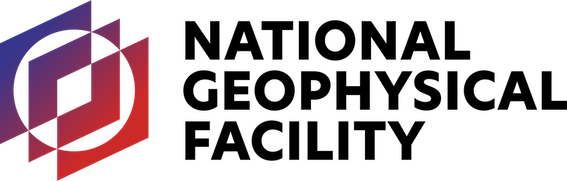
<!-- Image is embeded in this Markdown cell -->
<div style="display:flex; align-items:center; justify-content:space-between; gap:1rem;">
  <img src="attachment:NGF-Logo-FullName-RGB-Color.jpeg" style="max-height:120px;">
  <div style="text-align:right; line-height:1.25;">
    <p style="margin:0;">This module developed by David Mencin and the GeoLab Team: Alex Hamilton, Sophia Parafina, Sarah Wilson and Chad Trabant</p>
    <p style="margin:0;"><em>© 2025 EarthScope Consortium, NGF is operated on behalf of the NSF by EarthScope</em></p>
  </div>
</div>


# GNSS Interferometric Reflectometry (GNSS-IR): Introduction

This notebook introduces the physical basis of GNSS-IR and provides
an interactive two-ray simulation to build intuition for how antenna height
and satellite elevation angle control the interference pattern in SNR data.

**You will:**
- Understand the two-ray interference model.
- Relate phase difference to antenna height, wavelength, and elevation angle.
- Explore how changing geometry alters the oscillations seen in SNR vs. elevation.



## Learning Objectives
- Describe the GNSS-IR concept in terms of direct and reflected signals.
- Write the phase difference for a reflection from a flat surface.
- Predict where constructive/destructive interference occurs as elevation changes.
- Connect dominant oscillation frequency to antenna height.

## Prerequisites
- Python: `numpy`, `matplotlib`, optional `ipywidgets`
- GNSS basics (frequencies, wavelengths) and wave interference



## Physical Model (Two-Ray Approximation)

We model the received complex signal as the sum of a **direct** path and a **reflected** path from a locally flat surface.

Let:
- Antenna height above the reflecting plane: $h$
- Satellite elevation angle: $E$ (above the horizon)
- Carrier wavelength: $\lambda$
- Reflection coefficient magnitude: $0 \le \rho \le 1$
- Extra phase upon reflection (for horizontal polarization, near-grazing, $\pi$ is common as an approximation)

The **path length difference** between reflected and direct rays (for far-field geometry) is approximately

$$\Delta L \approx 2\,h\,\sin E$$

Thus the **phase difference** is

$$\Delta \phi(E) = \frac{2\pi}{\lambda}\,\Delta L \;\approx\; \frac{4\pi h}{\lambda}\,\sin E$$


If $A_d$ is the direct amplitude and $A_r = \rho\,A_d$ the reflected amplitude, assuming a coherence of 1 for the reflected signal the received power (proportional to SNR) becomes

$$
P(E) \;\propto\;
A_d^2 \left[
1 + \rho^2 +
2\rho \cos\!\left(
\frac{4\pi h}{\lambda}\sin E + \phi_r
\right)
\right].^\text{*derivation below}
$$ 

This predicts **oscillations** in SNR as a function of elevation angle $E$ with an argument proportional to $\sin E$. The dominant "frequency" of these oscillations in $\sin E$-space scales with $h/\lambda$.

> **Key take away:** Taller antennas (larger $h$) or shorter wavelengths (smaller $\lambda$) produce faster oscillations in SNR vs. elevation. This is the basis for estimating a **reflector height** from the observed oscillation frequency.


In [1]:

# Imports and constants
import numpy as np
import matplotlib.pyplot as plt

# GNSS L-band wavelengths (meters), approximate
c = 299792458.0
f_L1 = 1575.42e6
f_L2 = 1227.60e6
f_L5 = 1176.45e6
lambda_L1 = c / f_L1
lambda_L2 = c / f_L2
lambda_L5 = c / f_L5

lambda_L1, lambda_L2, lambda_L5


(0.19029367279836487, 0.24421021342456825, 0.25482804879085386)


## Two-Ray Simulator

The function below generates a synthetic "SNR-like" curve vs. elevation angle,
using the two-ray model. It lets you vary antenna height, wavelength, reflection
strength, and an optional coherence factor to mimic decorrelation (e.g., surface roughness).


In [2]:

def two_ray_snr(elev_deg, h=2.0, wavelength=0.19029367, rho=0.5, phi_r=np.pi, coherence=1.0):
    """
    Synthetic two-ray SNR-like power vs. elevation (degrees).
    elev_deg : array of elevation angles in degrees
    h        : antenna height above reflector [m]
    wavelength: carrier wavelength [m]
    rho      : reflection amplitude ratio (0..1)
    phi_r    : additional phase upon reflection (radians)
    coherence: multiplicative factor (0..1) to reduce interference term
    
    Returns: normalized power array ~ SNR (unitless)
    """
    E = np.deg2rad(elev_deg)
    delta_phi = (4.0*np.pi*h/wavelength) * np.sin(E)
    # Direct amplitude normalized to 1; reflected amplitude rho
    # Include optional coherence on the cross-term only
    P = 1.0 + rho**2 + 2.0*rho*coherence*np.cos(delta_phi + phi_r)
    # Normalize to mean 1 for easy comparison
    return P / np.mean(P)



### Quick Demo Plot (L1, h = 2 m)

Run the next cell to see a basic SNR vs. elevation simulation.


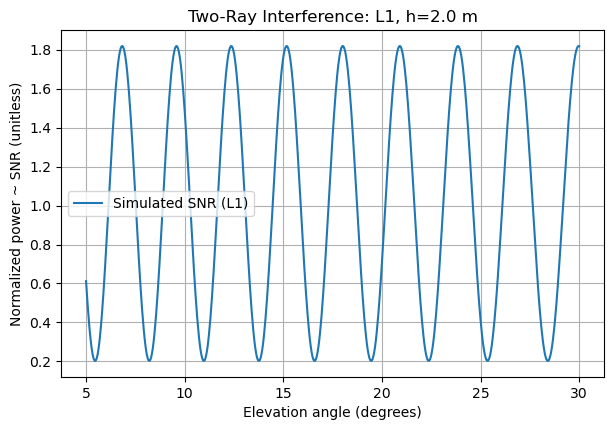

In [3]:

elev = np.linspace(5, 30, 600)  # typical GNSS-IR low-elevation window
P_L1 = two_ray_snr(elev, h=2.0, wavelength=lambda_L1, rho=0.5, phi_r=np.pi, coherence=1.0)

plt.figure(figsize=(7,4.5))
plt.plot(elev, P_L1, label='Simulated SNR (L1)')
plt.xlabel('Elevation angle (degrees)')
plt.ylabel('Normalized power ~ SNR (unitless)')
plt.title('Two-Ray Interference: L1, h=2.0 m')
plt.grid(True)
plt.legend()
plt.show()



### L1 vs L2 vs L5 Comparison

Shorter wavelength ⇒ faster oscillations as a function of elevation.


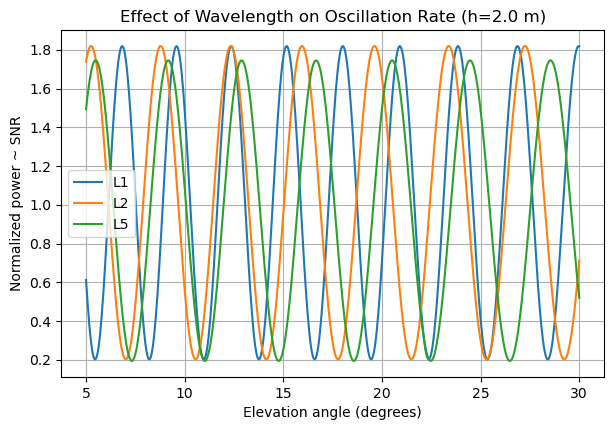

In [4]:

P_L2 = two_ray_snr(elev, h=2.0, wavelength=lambda_L2, rho=0.5, phi_r=np.pi, coherence=1.0)
P_L5 = two_ray_snr(elev, h=2.0, wavelength=lambda_L5, rho=0.5, phi_r=np.pi, coherence=1.0)

plt.figure(figsize=(7,4.5))
plt.plot(elev, P_L1, label='L1')
plt.plot(elev, P_L2, label='L2')
plt.plot(elev, P_L5, label='L5')
plt.xlabel('Elevation angle (degrees)')
plt.ylabel('Normalized power ~ SNR')
plt.title('Effect of Wavelength on Oscillation Rate (h=2.0 m)')
plt.grid(True)
plt.legend()
plt.show()



## From Oscillation to Reflector Height (Preview)

Because $\Delta \phi(E) \propto \frac{h}{\lambda}\sin E$, the oscillation "frequency" in $\sin E$-space
is proportional to $h/\lambda$. Later in the course, we will fit for the dominant component in
SNR vs. $\sin E$ to estimate **reflector height** $h$.

> **Rule of thumb:** doubling $h$ roughly doubles the oscillation rate; switching from L1 to L5 increases it further.



## (Optional) Interactive Widget

If `ipywidgets` is available in your environment, use the sliders to explore
the effect of antenna height, reflection strength, and coherence.


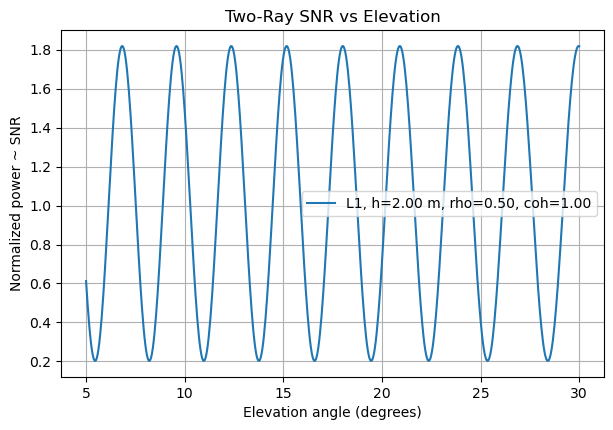

interactive(children=(FloatSlider(value=2.0, description='h', max=5.0, min=0.5), FloatSlider(value=0.5, descri…

In [5]:

try:
    import ipywidgets as widgets
    from ipywidgets import interact, FloatSlider
    
    def demo(h=2.0, rho=0.5, coherence=1.0, f_choice='L1'):
        wl = {'L1': lambda_L1, 'L2': lambda_L2, 'L5': lambda_L5}[f_choice]
        elev = np.linspace(5, 30, 600)
        P = two_ray_snr(elev, h=h, wavelength=wl, rho=rho, phi_r=np.pi, coherence=coherence)
        plt.figure(figsize=(7,4.5))
        plt.plot(elev, P, label=f'{f_choice}, h={h:.2f} m, rho={rho:.2f}, coh={coherence:.2f}')
        plt.xlabel('Elevation angle (degrees)')
        plt.ylabel('Normalized power ~ SNR')
        plt.title('Two-Ray SNR vs Elevation')
        plt.grid(True)
        plt.legend()
        plt.show()
    
    interact(demo,
             h=FloatSlider(min=0.5, max=5.0, step=0.1, value=2.0),
             rho=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.5),
             coherence=FloatSlider(min=0.0, max=1.0, step=0.05, value=1.0),
             f_choice=widgets.Dropdown(options=['L1','L2','L5'], value='L1'))
except Exception as e:
    print("ipywidgets not available or failed to render:", e)



## Fresnel Zone (Intuition)

For a flat reflector, the radius of the **first Fresnel zone** around the specular point is approximately
$$
r_1 \approx \sqrt{\frac{\lambda\,h}{2\sin E}}.
$$
Smaller $r_1$ (higher $E$, smaller $h$, or smaller $\lambda$) implies a more localized sensitivity footprint.
This simple expression is an approximation but provides good intuition for **spatial sensitivity**.


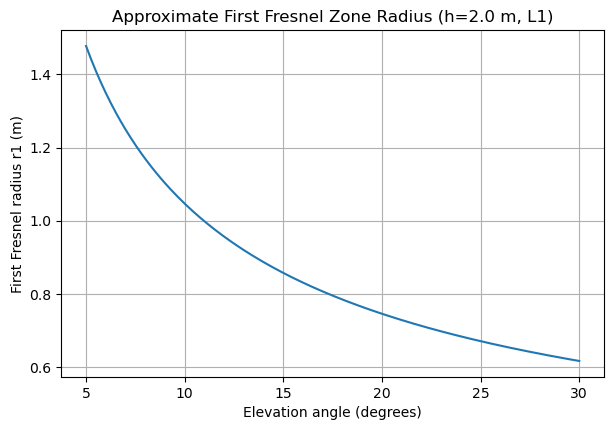

In [6]:

def fresnel_r1(h, elev_deg, wavelength):
    E = np.deg2rad(elev_deg)
    return np.sqrt((wavelength*h)/(2.0*np.sin(E)))

e_demo = np.linspace(5, 30, 200)
r1_L1 = fresnel_r1(2.0, e_demo, lambda_L1)

plt.figure(figsize=(7,4.5))
plt.plot(e_demo, r1_L1)
plt.xlabel('Elevation angle (degrees)')
plt.ylabel('First Fresnel radius r1 (m)')
plt.title('Approximate First Fresnel Zone Radius (h=2.0 m, L1)')
plt.grid(True)
plt.show()



## Exercises
1. **Phase Scaling:** For $h=3\,\text{m}$ at L1, by what factor does the oscillation rate change compared to $h=1.5\,\text{m}$?
2. **Wavelength Effect:** Compare simulated curves for L1 and L5 at the same $h$. Which oscillates faster and why?
3. **Fresnel Footprint:** Plot $r_1(E)$ for $h=\{1, 2, 4\}$ m at L1. Discuss implications for spatial averaging over rough surfaces.
4. **Decorrelation:** Decrease `coherence` from 1 to 0.3. How do the oscillations change? What field conditions might cause this?



## Next Notebook
**`02_GNSS_Geometry_and_Reflection_Point.ipynb`** — We will derive and visualize the specular reflection point and
explore how azimuth and elevation map the ground sensitivity pattern around a GNSS antenna.


### $^*$Derivation of Equation (3): Two-Ray Power Model

#### Model Received Field as a Phasor Sum
The total complex field at the antenna is the sum of a **direct** and a **reflected** wave:

$$
E_{\text{tot}}(E) = E_d(E) + E_r(E).
$$

Write the direct component as  

$$
E_d(E) = A_d\,e^{i\phi_d(E)}.
$$

The reflected signal experiences:
- a **reflection coefficient** (also refered to as the **Fresnel reflection coefficient**) $ \Gamma = \rho e^{i\phi_r} $  (magnitude $\rho$, phase $\phi_r$)
- an **extra phase delay** $ \Delta\phi(E) $ due to the longer path

so that

$$
E_r(E) = \Gamma A_d e^{i[\phi_d(E) + \Delta\phi(E)]}
       = \rho A_d e^{i[\phi_d(E) + \Delta\phi(E) + \phi_r]}.
$$

Factoring out the common phase $ \phi_d(E) $:

$$
E_{\text{tot}}(E) = A_d e^{i\phi_d(E)} \big[ 1 + \rho e^{i(\Delta\phi(E) + \phi_r)} \big].
$$


#### Compute the Received Power
The measured power (SNR proxy) is proportional to the squared magnitude of the total field:

$$
P(E) \propto |E_{\text{tot}}(E)|^2
            = A_d^2 \big| 1 + \rho e^{i(\Delta\phi(E) + \phi_r)} \big|^2.
$$

Expanding:

$$
|1 + \rho e^{i\psi}|^2
= (1 + \rho e^{i\psi})(1 + \rho e^{-i\psi})
= 1 + \rho^2 + 2\rho\cos\psi,
$$
where $ \psi = \Delta\phi(E) + \phi_r $.

Thus,

$$
P(E) \propto A_d^2 \big[ 1 + \rho^2 + 2\rho\cos(\Delta\phi(E) + \phi_r) \big].
$$


#### Substitute in the Geometric Phase Delay
From the two-ray geometry:

$$
\Delta\phi(E) = \frac{2\pi}{\lambda}\,\Delta L(E)
              \approx \frac{2\pi}{\lambda}(2h\sin E)
              = \frac{4\pi h}{\lambda}\sin E.
$$

Substituting back gives the final form:

$$
\boxed{
P(E) \propto A_d^2
\left[
1 + \rho^2 + 2\rho\cos\!\left(
\frac{4\pi h}{\lambda}\sin E + \phi_r
\right)
\right].
}
$$